Прогнозирование уровня диммирования уличного освещения

Модель на основе Gradient Boosting для предсказания оптимального уровня освещения

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor  # альтернатива
import joblib
import warnings

warnings.filterwarnings('ignore')

In [18]:
df = pd.read_csv('device_data.csv')
print(f"Загружено {len(df)} записей")
df.head()

Загружено 42 записей


,id,timestamp,serial_number,latitude,longitude,car_count,traffic_speed,traffic_density,pedestrian_count,pedestrian_density,ambient_light,lighting_class,lamp_power,weather,dimming_level
0,1,2025-03-02T00:00:00,1,47.22486,39.702285,9,24.38,0.11,0,0.00,151.0,B1,75.0,rain,75.0
1,2,2025-03-02T01:00:00,1,47.22486,39.702285,7,30.23,0.09,2,0.05,98.0,B1,52.5,rain,80.0
2,3,2025-03-02T02:00:00,1,47.22486,39.702285,5,21.39,0.06,0,0.00,79.0,B1,52.5,rain,75.0
3,4,2025-03-02T03:00:00,1,47.22486,39.702285,4,23.99,0.05,0,0.00,20.0,B1,52.5,rain,75.0
4,5,2025-03-02T04:00:00,1,47.22486,39.702285,1,11.50,0.01,2,0.05,7.0,B1,52.5,rain,70.0


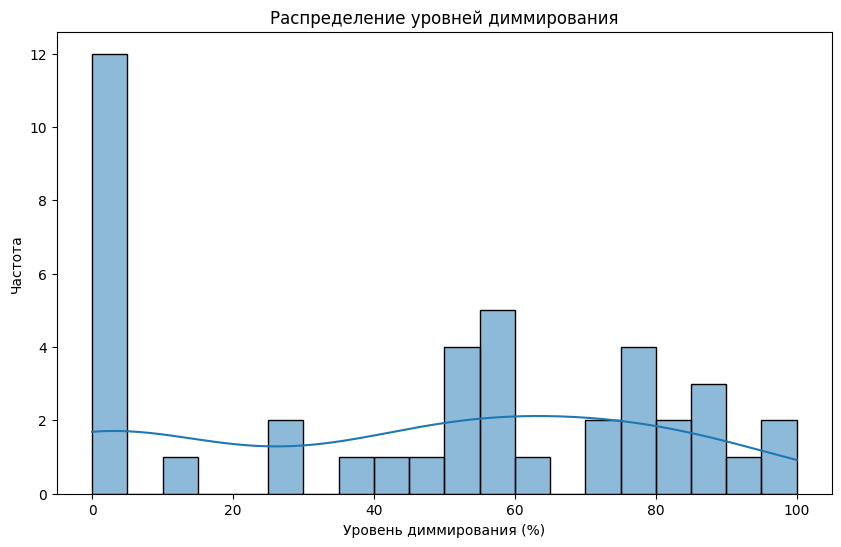

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(df['dimming_level'], bins=20, kde=True)
plt.title('Распределение уровней диммирования')
plt.xlabel('Уровень диммирования (%)')
plt.ylabel('Частота')
plt.show()

In [20]:
def prepare_data(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    y = df['dimming_level']
    X = df.drop(['id', 'timestamp', 'lamp_power', 'dimming_level'], axis=1)
    return X, y

X, y = prepare_data(df)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Тренировочный набор: {X_train.shape[0]} записей")
print(f"Тестовый набор: {X_test.shape[0]} записей")

Тренировочный набор: 33 записей
Тестовый набор: 9 записей


In [22]:
numeric_features = ['serial_number', 'latitude', 'longitude', 
                   'car_count', 'traffic_speed', 'traffic_density',
                   'pedestrian_count', 'pedestrian_density', 
                   'ambient_light', 'hour', 
                   'day_of_week', 'is_weekend']

categorical_features = ['lighting_class', 'weather']

In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

preprocessor.fit(X_train)
X_test_processed = preprocessor.transform(X_test)

In [29]:
model = XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    early_stopping_rounds=10,
    eval_metric='mae'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

In [30]:
pipeline.fit(
    X_train, y_train,
    model__eval_set=[(X_test_processed, y_test)],
    model__verbose=True
)

[0]	validation_0-mae:22.39057
[1]	validation_0-mae:20.60614
[2]	validation_0-mae:19.22505
[3]	validation_0-mae:17.69587
[4]	validation_0-mae:16.59874
[5]	validation_0-mae:15.28541
[6]	validation_0-mae:14.32135
[7]	validation_0-mae:13.57690
[8]	validation_0-mae:12.48141
[9]	validation_0-mae:11.94967
[10]	validation_0-mae:11.38712
[11]	validation_0-mae:10.85315
[12]	validation_0-mae:10.33072
[13]	validation_0-mae:9.81147
[14]	validation_0-mae:9.43836
[15]	validation_0-mae:9.02156
[16]	validation_0-mae:8.69908
[17]	validation_0-mae:8.47321
[18]	validation_0-mae:8.34369
[19]	validation_0-mae:8.07168
[20]	validation_0-mae:7.86969
[21]	validation_0-mae:7.59566
[22]	validation_0-mae:7.52724
[23]	validation_0-mae:7.41476
[24]	validation_0-mae:7.29652
[25]	validation_0-mae:7.18289
[26]	validation_0-mae:7.11392
[27]	validation_0-mae:7.02776
[28]	validation_0-mae:6.90883
[29]	validation_0-mae:6.71431
[30]	validation_0-mae:6.60978
[31]	validation_0-mae:6.53351
[32]	validation_0-mae:6.48983
[33]	va

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['serial_number', 'latitude',
                                                   'longitude', 'car_count',
                                                   'traffic_speed',
                                                   'traffic_density',
                                                   'pedestrian_count',
                                                   'pedestrian_density',
                                                   'ambient_light', 'hour',
                                                   'day_of_week',
                                                   'is_weekend']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['lighting_class',
                                                   'weather'])])),
                ('mod...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=None,
                              num_parallel_tree=None, ...))])

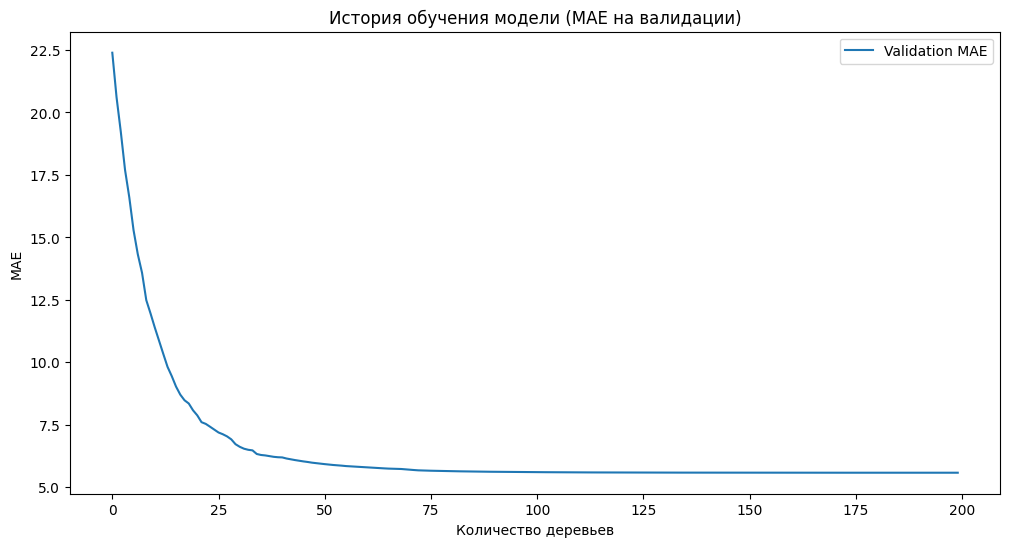

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(model.evals_result()['validation_0']['mae'], label='Validation MAE')
plt.title('История обучения модели (MAE на валидации)')
plt.xlabel('Количество деревьев')
plt.ylabel('MAE')
plt.legend()
plt.show()

Средняя абсолютная ошибка (MAE): 5.57
Коэффициент детерминации (R²): 0.92


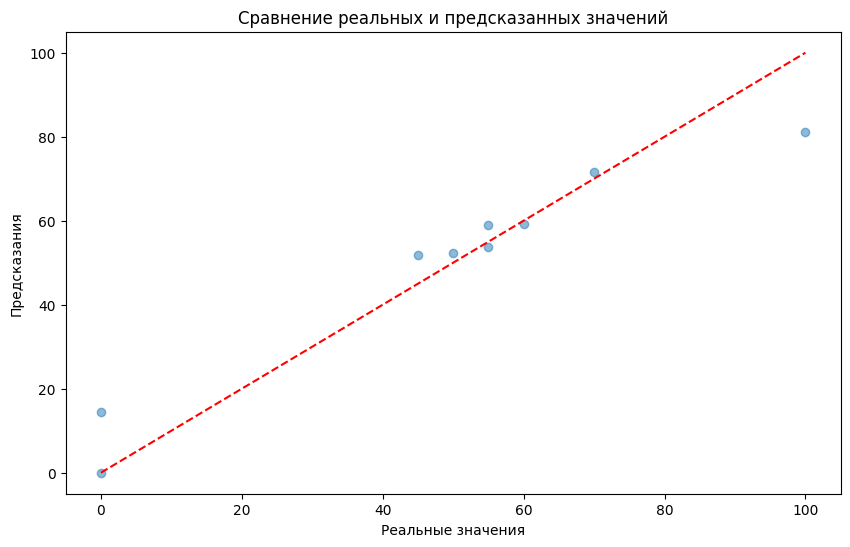

In [32]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
    print(f"Коэффициент детерминации (R²): {r2:.2f}")
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.xlabel('Реальные значения')
    plt.ylabel('Предсказания')
    plt.title('Сравнение реальных и предсказанных значений')
    plt.show()
    
    return mae, r2

mae, r2 = evaluate_model(pipeline, X_test, y_test)

In [33]:
model_filename = 'model_xgboost.joblib'
joblib.dump(pipeline, model_filename)
print(f"Модель сохранена как {model_filename}")

Модель сохранена как model_xgboost.joblib


Использование:

In [44]:
def predict_dimming(sample_data):
    model = joblib.load(model_filename)
    prediction = model.predict(pd.DataFrame([sample_data]))[0]
    return max(0, min(100, prediction))

sample_data = {
    'serial_number': 1,
    'latitude': 47.22486,
    'longitude': 39.702285,
    'car_count': 9,
    'traffic_speed': 24.38,
    'traffic_density': 0.11,
    'pedestrian_count': 0,
    'pedestrian_density': 0.0,
    'ambient_light': 151.0,
    'lighting_class': 'B1',
    'weather': 'rain',
    'hour': 0,
    'day_of_week': 3,
    'is_weekend': 0
}

prediction = predict_dimming(sample_data)
print(f"Предсказанный уровень диммирования: {prediction:.1f}%")

Предсказанный уровень диммирования: 58.8%
